In [2]:
# %load_ext autoreload
# %autoreload 2

import sys
import os
import pandas as pd
from datetime import datetime, timedelta

# Add src directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src import config
from src.data_utils import transform_ts_data_info_features_and_target, split_time_series_data
import hopsworks


In [3]:
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()

# Load feature group
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

# Create feature view (only once)
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"✅ Created feature view: {config.FEATURE_VIEW_NAME}")
except Exception as e:
    print(f"⚠️ Skipping feature view creation: {e}")

# Load feature view
feature_view = feature_store.get_feature_view(
    name=config.FEATURE_VIEW_NAME,
    version=config.FEATURE_VIEW_VERSION,
)


2025-05-10 05:34:40,817 INFO: Initializing external client
2025-05-10 05:34:40,817 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-10 05:34:42,166 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214682
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214682/fs/1202313/fv/citi_bike_ds/version/1
✅ Created feature view: citi_bike_ds


In [4]:
ts_data, _ = feature_view.training_data(description="Time-series hourly Citi Bike rides")
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


In [5]:
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # remove timezone
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # e.g., 2025-03


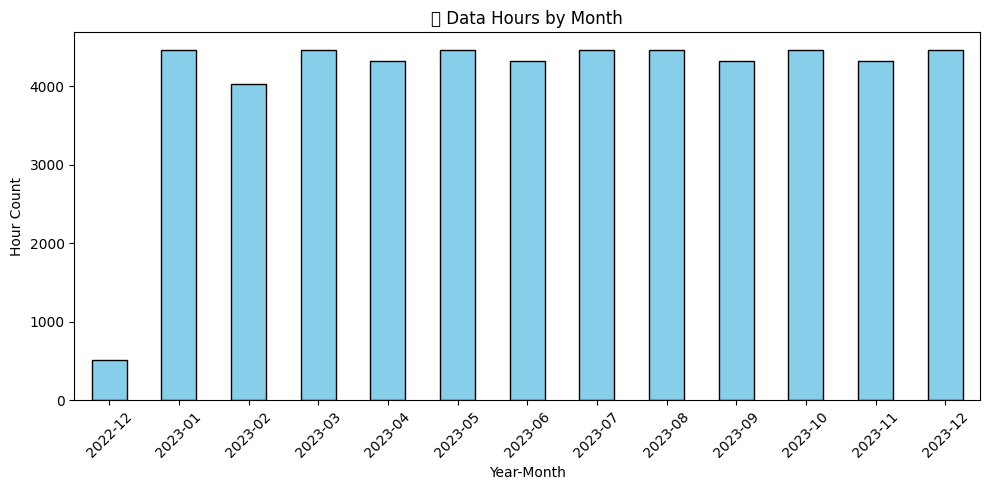

In [6]:
import matplotlib.pyplot as plt

month_counts = ts_data.groupby("year_month").size()
ax = month_counts.plot(kind="bar", figsize=(10, 5), color="skyblue", edgecolor="black")
ax.set_title("🕒 Data Hours by Month")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Hour Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


In [7]:
ts_data = ts_data[(ts_data["year_month"] >= pd.Period("2023-01")) & 
                  (ts_data["year_month"] <= pd.Period("2023-03"))]

ts_data.drop(columns=["year_month"], inplace=True)


In [8]:
features, targets = transform_ts_data_info_features_and_target(
    ts_data, window_size=24*28, step_size=23  # 28-day window, 1-hour step
)
features_targets = features.copy()
features_targets["target"] = targets


In [28]:
cutoff_date = pd.Timestamp("2023-03-15")

X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("📅 Max date in dataset:", features_targets["pickup_hour"].max())


X_train: (427, 674)
X_test: (108, 674)
📅 Max date in dataset: 2023-03-31 18:00:00


In [29]:
from src.pipeline_utils import get_pipeline

best_parameters = {
    "bagging_fraction": 0.7, "bagging_freq": 1, "colsample_bytree": 0.6,
    "feature_fraction": 0.6, "learning_rate": 0.05, "max_depth": 30,
    "n_estimators": 200, "num_leaves": 256, "reg_alpha": 1.0, "reg_lambda": 0.1
}

pipeline = get_pipeline(**best_parameters)
pipeline.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26882
[LightGBM] [Info] Number of data points in the train set: 427, number of used features: 675
[LightGBM] [I

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000001B3B403A8E0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.7, bagging_freq=1,
                               colsample_bytree=0.6, feature_fraction=0.6,
                               learning_rate=0.05, max_depth=30,
                               n_estimators=200, num_leaves=256, reg_alpha=1.0,
                               reg_lambda=0.1))])

In [30]:
from sklearn.metrics import mean_absolute_error

preds = pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, preds)
print(f"📉 Test MAE: {test_mae:.4f}")


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
📉 Test MAE: 3.4383
